In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [112]:
import json

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.spatial.distance import euclidean
from math import pow

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

In [3]:
%matplotlib inline

In [95]:
import gensim

d:\Anaconda3\envs\ml_itmo\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Загрузка данных

In [4]:
with open('posts_1.json', 'r', encoding='utf-8') as f:
    file_content = f.readlines()

In [5]:
raw_data = json.loads('[{}]'.format(','.join(file_content)))

In [6]:
raw_data[0]

{'_id': '-29425083_5664',
 'attachments': [{'photo': {'access_key': '234cdcf64007f37550',
    'album_id': -7,
    'date': 1462457034,
    'height': 843,
    'id': 411952969,
    'owner_id': -29425083,
    'photo_1280': 'https://pp.userapi.com/c631524/v631524059/338eb/NW3ZUU-Ki9s.jpg',
    'photo_130': 'https://pp.userapi.com/c631524/v631524059/338e8/9dRq7GCXAqE.jpg',
    'photo_604': 'https://pp.userapi.com/c631524/v631524059/338e9/3or7pJ0N9gk.jpg',
    'photo_75': 'https://pp.userapi.com/c631524/v631524059/338e7/J2ETzuoPOXg.jpg',
    'photo_807': 'https://pp.userapi.com/c631524/v631524059/338ea/IIyLJ9QMKvY.jpg',
    'text': '',
    'user_id': 100,
    'width': 843},
   'type': 'photo'}],
 'comments': {'can_post': 1, 'count': 326},
 'date': 1462457031,
 'from_id': -29425083,
 'id': 5664,
 'is_pinned': 1,
 'key': '-29425083_5664',
 'likes': {'can_like': 1, 'can_publish': 1, 'count': 78, 'user_likes': 0},
 'marked_as_ads': 0,
 'owner_id': -29425083,
 'post_source': {'type': 'vk'},
 'post

# Препроцессинг

## Удаление стоп-слов и другая очистка + стэмминг


In [7]:
tokenizer = RegexpTokenizer(r'[а-я]+')
#tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('russian')
sw = stopwords.words('russian')

def nltk_preprocess(sentence):
    sentence = sentence.lower()
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [stemmer.stem(word) for word in tokens if word not in sw]
    return ' '.join(filtered_words)

In [8]:
bank_posts = [nltk_preprocess(post['text']) for post in raw_data]

In [9]:
bank_posts[0]

'хот зада вопрос наш сообществ обрат вниман банк санкт петербург уточня информац двух официальн профил анастас сидоров банк санкт петербург как обстоятельств банк запрашива клиент полн номер карт код пин код берег ник сообща полн дан сво банковск карт безопасн'

# Векторизация

In [43]:
vectorizer = TfidfVectorizer()
bank_posts_vectorized = vectorizer.fit_transform(bank_posts)
bank_posts_vectorized.shape

(400, 4222)

# Визуализация

In [59]:
def pca2_visualization(bank_posts_vectorized, *args, **kwargs):
    pca2 = PCA(n_components=2)
    bank_posts_pca2 = pca2.fit_transform(bank_posts_vectorized.toarray())
    scatter(*bank_posts_pca2.T, *args, **kwargs)

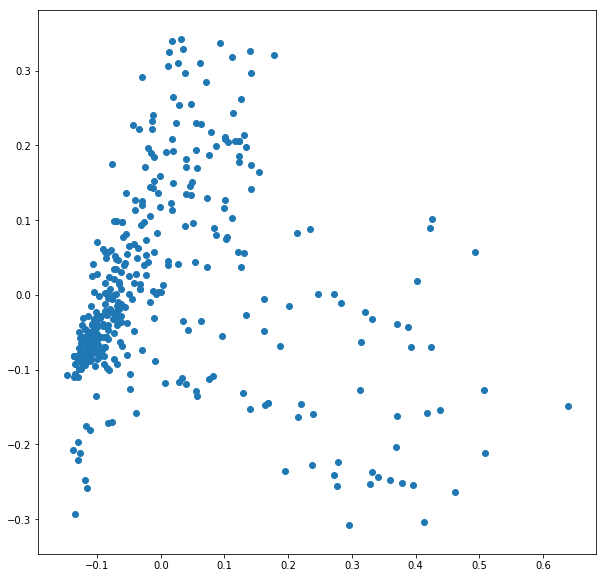

In [60]:
figsize(10, 10)
pca2_visualization(bank_posts_vectorized)

# Кластеризация

## Методы оценки качества кластеризации

### Фабрика для различных оценок

In [84]:
def make_scorer(score_func, greater_is_better=True):
    def wrapper(estimator, X):
        X_trans = estimator.fit_transform(X)
        clusters = estimator.predict(X)
        score = score_func(X_trans, clusters)
        return score if greater_is_better else -1 * score
    return wrapper

### Индексы оценки кластеризации

#### Индекс Данна

In [12]:
def dunn_index(X, clusters):
    if type(X) != ndarray:
        X = X.toarray()
    
    # Разбиение на массивы по кластерам
    clusters_number = clusters.max() + 1
    clusters_data = []
    for cluster_index in range(clusters_number):
        cluster = {}
        X_cluster = X[clusters == cluster_index, :]
        if X_cluster.size == 0:
            raise RuntimeError('cluster {}'.format(cluster_index))
        cluster['X'] = X_cluster
        cluster['centroid'] = cluster['X'].mean(axis=0).ravel()
        cluster['distances'] = pdist(X_cluster)
        clusters_data.append(cluster)
    
    # Разброс внутри класетров (по наиболее отдаленным точкам кластеров)
    max_delta_inside = 0
    for cluster in clusters_data:
        distances = cluster['distances']
        delta = distances.max()
        if delta > max_delta_inside:
            max_delta_inside = delta
        cluster['delta'] = delta
    
    # Разброс самих кластеров (по расстоянию между центрами)
    centroids_distances = pdist(array([cluster['centroid'] for cluster in clusters_data]))
    min_delta_between = centroids_distances.min()
    
    return min_delta_between / max_delta_inside

#### Индекс Дэвиса-Болдэна

In [13]:
def davies_bouldin_index(X, clusters, p=2):
    # Разбиение на массивы по кластерам
    clusters_number = clusters.max() + 1
    clusters_data = []
    for cluster_index in range(clusters_number):
        cluster = {}
        cluster['X'] = X[clusters == cluster_index, :]
        cluster['label'] = cluster_index
        cluster['centroid'] = cluster['X'].mean(axis=0).ravel()
        clusters_data.append(cluster)
    
    # Вычисление Si
    for cluster in clusters_data:
        X_cluster = cluster['X']
        centroid = cluster['centroid']
        s = power(power(power(X_cluster - centroid, p).sum(axis=0), 1 / p).sum() / X_cluster.shape[0], 1 / p)
        cluster['s'] = s
    
    # Вычисление Mij
    ms = zeros((clusters_number, clusters_number))
    for i in range(clusters_number):
        for j in range(clusters_number):
            if i >= j:
                continue
            mij = pow(power(clusters_data[i]['centroid'] - clusters_data[j]['centroid'], p).sum(axis=0), 1 / p)
            ms[i, j] = mij

    # Вычисление Rij
    rs = zeros((clusters_number, clusters_number))
    for i in range(clusters_number):
        for j in range(clusters_number):
            if i >= j:
                continue
            rij = (clusters_data[i]['s'] + clusters_data[j]['s']) / ms[i, j]
            rs[i, j] = rij
            rs[j, i] = rij
    return rs.max(axis=1).mean()

### Вспомогательные классы

#### Преобразователь sparse матрицы в dense

In [14]:
class ToDense(TransformerMixin, BaseEstimator):
    def fit(self, *args, **kwargs):
        return self

    def transform(self, x):
        return x.toarray()

#### Иерархическая кластеризация для использования в пайплайне

In [15]:
class AgglomerativeClusteringPipeline(TransformerMixin, AgglomerativeClustering):
    def transform(self, X):
        return X
    
    def predict(self, X, y=None):
        return self.labels_

### Параметры для подбора оптимального значения

In [113]:
pipe = Pipeline([
    ('vectorizer', None),
    ('todense', ToDense()),
    ('dim_red', None),
    ('clusterization', None), 
])

params = [
    {
        'dim_red': [None],
        'vectorizer': [TfidfVectorizer()],   # + LDA, doc2vec
        'clusterization': [KMeans(), AgglomerativeClusteringPipeline()],
        'clusterization__n_clusters': [2, 3, 4, 5, 10, 20, 30, 50, 70, 100]
    },
    {
        'dim_red': [PCA()],
        'vectorizer': [TfidfVectorizer()],
        'clusterization': [KMeans(), AgglomerativeClusteringPipeline()],
        'dim_red__n_components': [2, 3, 5, 10, 20, 50, 100, 200, 600],
        'clusterization__n_clusters': [2, 3, 4, 5, 10, 20, 30, 50, 70, 100]
    },
#     {
#         'dim_red': [None],
#         'vectorizer': [LatentDirichletAllocation()],
#         'clusterization': [KMeans(), AgglomerativeClusteringPipeline()],
#         'vectorizer__n_components': [5, 10, 20, 50, 100, 200, 600],
#         'clusterization__n_clusters': [2, 3, 4, 5, 10, 20, 30, 50, 70, 100]
#     },
#     {
#         'dim_red': [PCA()],
#         'vectorizer': [LatentDirichletAllocation()],
#         'clusterization': [KMeans(), AgglomerativeClusteringPipeline()],
#         'dim_red__n_components': [2, 3, 5, 10, 20, 50, 100, 200, 600],
#         'vectorizer__n_components': [5, 10, 20, 50, 100, 200, 600],
#         'clusterization__n_clusters': [2, 3, 4, 5, 10, 20, 30, 50, 70, 100]
#     },
]

### Поиск оптимального значения

#### Оценка с помощью silhouette_score

In [114]:
grid_cv_sc = GridSearchCV(pipe, 
                          params, 
                          scoring=make_scorer(silhouette_score, greater_is_better=True), 
                          cv=3, 
                          return_train_score=False)
grid_cv_sc.fit(bank_posts)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', None), ('todense', ToDense()), ('dim_red', None), ('clusterization', None)]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'dim_red': [None], 'vectorizer': [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preproc...5, 10, 20, 50, 100, 200, 600], 'clusterization__n_clusters': [2, 3, 4, 5, 10, 20, 30, 50, 70, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=<function make_scorer.<locals>.wrapper at 0x00000235294C91E0>,
       verbose=0)

In [115]:
grid_cv_sc.best_estimator_.steps

[('vectorizer',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words=None, strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None)),
 ('todense', ToDense()),
 ('dim_red',
  PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('clusterization',
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
      n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
      random_state=None, tol=0.0001, verbose=0))]

In [116]:
grid_cv_sc.best_score_

0.70750982228252313

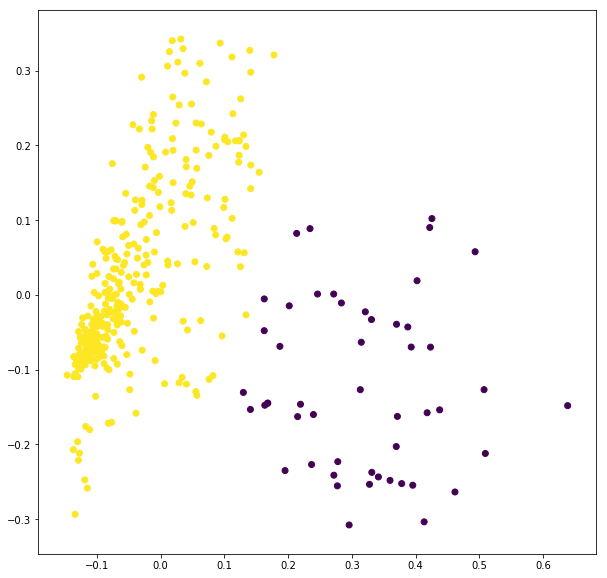

In [117]:
figsize(10, 10)
pca2_visualization(bank_posts_vectorized, c=grid_cv_sc.predict(bank_posts))

In [124]:
grid_cv_sc.best_estimator_.steps[0][1].get_feature_names()

['абонемент',
 'абонент',
 'абсолютн',
 'абсурд',
 'ав',
 'авансов',
 'авар',
 'аватар',
 'август',
 'авиабилет',
 'авиакомпан',
 'аврор',
 'авт',
 'автобусн',
 'автов',
 'автограф',
 'автокоррекц',
 'автокред',
 'автокредит',
 'автокредитован',
 'автоматизац',
 'автоматизирова',
 'автоматическ',
 'автомобил',
 'автомобилист',
 'автомобильн',
 'автоплатеж',
 'авторизац',
 'авторизова',
 'авторитетн',
 'авторск',
 'автостоянк',
 'автостоянок',
 'агент',
 'аграрн',
 'адвокат',
 'администрац',
 'адмира',
 'адмиралтейск',
 'адр',
 'адрес',
 'адресн',
 'азбук',
 'азс',
 'айсберг',
 'академ',
 'акварел',
 'акватор',
 'аквилон',
 'аккаунт',
 'аккредитова',
 'активац',
 'активизирова',
 'активир',
 'активн',
 'актуальн',
 'акц',
 'акцииотб',
 'акцииотбпсб',
 'акцииотбспб',
 'алекс',
 'александр',
 'александровск',
 'александрсавел',
 'алкогол',
 'алл',
 'алле',
 'аллеяпарящихзонтик',
 'аллеяяркихзонтик',
 'альб',
 'альбом',
 'альтернатив',
 'альф',
 'альфаюрист',
 'альянс',
 'амал',
 'американ

In [127]:
grid_cv_sc.best_estimator_.steps[0][1].vocabulary_.get('абсолютн')

2

#### Оценка с помощью индекса Данна

In [30]:
grid_cv = GridSearchCV(pipe, 
                       params, 
                       scoring=make_scorer(dunn_index, greater_is_better=True), 
                       cv=3, 
                       return_train_score=False)
grid_cv.fit(bank_posts_vectorized.toarray())

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
grid_cv.best_estimator_.steps

In [ ]:
grid_cv.best_score_

#### Оценка с помощью индекса Дэвиса-Болдэна

In [66]:
grid_cv_db = GridSearchCV(pipe, 
                          params, 
                          scoring=make_scorer(davies_bouldin_index, greater_is_better=False), 
                          cv=3, 
                          return_train_score=False)
grid_cv_db.fit(bank_posts_vectorized.toarray())

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None, steps=[('dim_red', None), ('clusterization', None)]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'dim_red': [None], 'clusterization': [KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), AgglomerativeClusteringPipeline(affinity='euclidean',
        ...5, 10, 20, 50, 100, 200, 600], 'clusterization__n_clusters': [2, 3, 4, 5, 10, 20, 30, 50, 70, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=<function make_scorer.<locals>.wrapper at 0x000002352852D950>,
       verbose=0)

In [67]:
grid_cv_db.best_estimator_.steps

[('dim_red',
  PCA(copy=True, iterated_power='auto', n_components=600, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('clusterization',
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
      n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
      random_state=None, tol=0.0001, verbose=0))]

In [68]:
grid_cv_db.best_score_

-0.71303944087715398

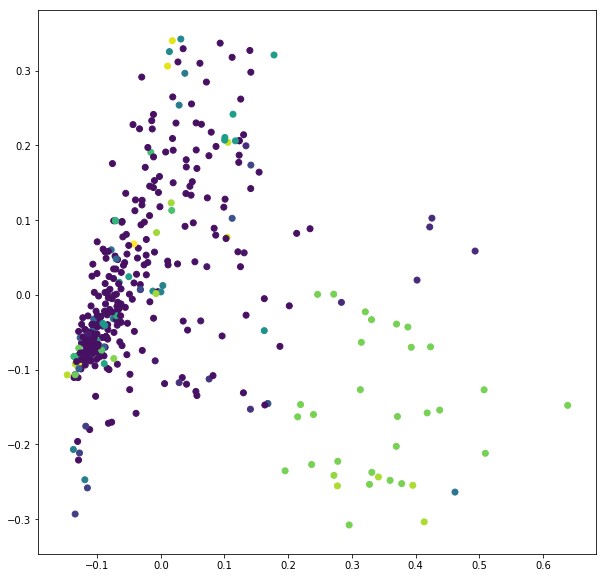

In [69]:
pca2_visualization(bank_posts_vectorized, c=grid_cv_db.predict(bank_posts_vectorized.toarray()))

## Определение количества кластеров

## K-means

## Иерархическая

### Дендрограмма

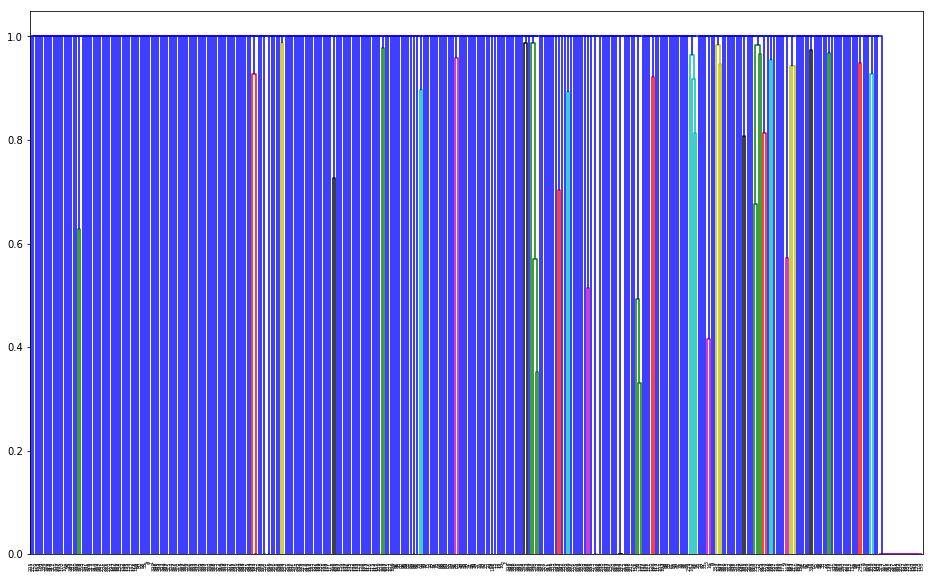

In [75]:
figsize(16,10)
dendro_dict = hierarchy.dendrogram(hierarchy.linkage(bank_posts_vectorized.toarray()), color_threshold=.99)

In [73]:
bank_posts[221]

'момент запуск сервис appl pa накоп вопрос сегодн отвеча сам популярн вопрос хоч appl pa подключ ответ подключен карт appl pa iphon se iphon 6 нов модел такж appl watch откройт приложен wallet косн значк введ дан ваш карт следу инструкц экран вопрос работа appl pa мо устройств appl ответ appl pa доступ пользовател устройств iphon модел 6 7 поколен такж iphon se ipad ipad pro ipad air 2 ipad min 4 ipad min 3 appl watch appl watch series 1 2 appl watch 1 го поколен mac вопрос карт ярк подключ appl pa ответ вопрос оплат appl pa счита оплат карт ответ имен вопрос оплачива покупк смартфон appl привяза карт ваш банк будут начисля бонус ярк ответ кажд бонусируем покупк будут начисля бонус ваш ставк 0 5 2 вопрос мог возмест ярк бонус стоимост поездк метр котор оплат appl pa ответ возмещен операц совершен помощ appl pa доступн оплат карт вопрос планир подключен карт vis систем appl pa ответ планиру нача предоставля сервис appl pa карт vis 2017 год точн информац срок пок нача пользова сервис app

In [91]:
dendro_dict['ivl']

['363',
 '155',
 '395',
 '227',
 '131',
 '101',
 '356',
 '316',
 '300',
 '205',
 '29',
 '373',
 '359',
 '348',
 '324',
 '299',
 '220',
 '207',
 '206',
 '188',
 '124',
 '80',
 '60',
 '389',
 '387',
 '385',
 '383',
 '382',
 '376',
 '378',
 '375',
 '371',
 '369',
 '364',
 '361',
 '360',
 '358',
 '335',
 '333',
 '331',
 '329',
 '325',
 '321',
 '318',
 '312',
 '276',
 '260',
 '259',
 '273',
 '252',
 '262',
 '244',
 '229',
 '226',
 '219',
 '215',
 '201',
 '198',
 '194',
 '181',
 '172',
 '170',
 '167',
 '164',
 '159',
 '158',
 '153',
 '152',
 '146',
 '135',
 '134',
 '125',
 '106',
 '89',
 '86',
 '84',
 '78',
 '69',
 '68',
 '64',
 '62',
 '55',
 '42',
 '31',
 '30',
 '25',
 '24',
 '12',
 '4',
 '0',
 '399',
 '397',
 '392',
 '390',
 '386',
 '372',
 '368',
 '367',
 '355',
 '353',
 '343',
 '341',
 '339',
 '338',
 '337',
 '332',
 '328',
 '326',
 '322',
 '319',
 '313',
 '311',
 '310',
 '309',
 '306',
 '304',
 '303',
 '298',
 '296',
 '294',
 '289',
 '287',
 '286',
 '284',
 '278',
 '277',
 '275',
 '269'